Import Libraries

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

Data preprocessing

In [ ]:
# Load the dataset
file_path = 'D:/cars.csv'

cars_df = pd.read_csv(file_path)

# Display basic info and the first few rows (optional)
cars_df.info()
print("First few rows before preprocessing:")
print(cars_df.head())

# Step 1: Cleaning Missing Values
cars_df.replace(["N/A", "TBD", "N/A, Electric"], np.nan, inplace=True)
# Define a function to convert prices to USD
def convert_to_usd(price):
    if pd.isna(price):
        return np.nan
    if 'SAR' in price:
        return float(price.replace('SAR', '').replace(',', '').strip()) * 0.27
    elif 'EGP' in price:
        return float(price.replace('EGP', '').replace(',', '').strip()) * 0.032
    elif 'BHD' in price:
        return float(price.replace('BHD', '').replace(',', '').strip()) * 2.65
    elif 'QAR' in price:
        return float(price.replace('QAR', '').replace(',', '').strip()) * 0.27
    elif 'OMR' in price:
        return float(price.replace('OMR', '').replace(',', '').strip()) * 2.60
    elif 'KWD' in price:
        return float(price.replace('KWD', '').replace(',', '').strip()) * 3.30
    elif 'AED' in price:
        return float(price.replace('AED', '').replace(',', '').strip()) * 0.27
    else:
        return np.nan

# Apply the conversion function to the price column
cars_df['price'] = cars_df['price'].apply(convert_to_usd)

# Check for missing values before imputation
print("Missing values before imputation:")
print(cars_df.isnull().sum())

# Impute missing prices with the mean
price_imputer = SimpleImputer(strategy='mean')
cars_df['price'] = price_imputer.fit_transform(cars_df[['price']])

cars_df['cylinder'] = pd.to_numeric(cars_df['cylinder'], errors='coerce')
cars_df['engine_capacity'] = pd.to_numeric(cars_df['engine_capacity'], errors='coerce')
cars_df['horse_power'] = pd.to_numeric(cars_df['horse_power'], errors='coerce')
cars_df['top_speed'] = pd.to_numeric(cars_df['top_speed'], errors='coerce')
# Extract numeric values from 'seats' column
cars_df['seats'] = cars_df['seats'].str.extract(r'(\d+)').astype(float)

# Define numerical and categorical features
numerical_features = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']
categorical_features = ['brand', 'country']

# Create an imputer for numerical features
numerical_imputer = SimpleImputer(strategy='median')

# Apply the imputer to numerical features
cars_df[numerical_features] = numerical_imputer.fit_transform(cars_df[numerical_features])

# Convert imputed numerical features to integers
cars_df[numerical_features] = cars_df[numerical_features].astype(int)

# Copy cars_df to cars_df_copy
cars_df_copy = cars_df.copy()

# Display basic info and the first few rows after preprocessing
print("\nFirst few rows after preprocessing:")
print(cars_df.head())

# Check for missing values
print("\nMissing values after preprocessing:")
print(cars_df.isnull().sum())

# Check data types
print("\nData types after preprocessing:")
print(cars_df.dtypes)


# Step 2: Encoding Categorical Features and Scaling Numerical Features

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the transformations
cars_df_transformed = preprocessor.fit_transform(cars_df)

# Get the transformed column names
numerical_columns = numerical_features
categorical_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
transformed_columns = np.concatenate([numerical_columns, categorical_columns])

# Convert the transformed data back to a DataFrame
cars_df_transformed = pd.DataFrame(cars_df_transformed.toarray(), columns=transformed_columns)

# Display the transformed DataFrame
print("\nTransformed DataFrame:")
print(cars_df_transformed.head())

# Step 3: Splitting the Dataset
X = cars_df.drop(columns=['price', 'car name'])
y = cars_df['price']

# Split the dataset into 60% training and 40% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary set into 50% validation and 50% test (20% each of the original dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply the preprocessor to the training, validation, and test sets
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Convert to dense arrays if they are sparse
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_val.toarray() if hasattr(X_val, "toarray") else X_val
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Check the lengths of the datasets
print("Length of training set:", len(X_train_dense))
print("Length of validation set:", len(X_val_dense))
print("Length of test set:", len(X_test_dense))


# Step 2.1: Encoding Features using LAbel Encoding
# Apply Label Encoding to categorical features
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    cars_df_copy[feature] = le.fit_transform(cars_df_copy[feature].astype(str))
    label_encoders[feature] = le

# Create an imputer for numerical features
numerical_imputer = SimpleImputer(strategy='median')

# Apply the imputer to numerical features
cars_df_copy[numerical_features] = numerical_imputer.fit_transform(cars_df_copy[numerical_features])

# Convert imputed numerical features to integers
cars_df_copy[numerical_features] = cars_df_copy[numerical_features].astype(int)

# Step 3.1: Split the dataset into features and target variable
x_copy = cars_df_copy.drop(columns=['price', 'car name'])
y_copy = cars_df_copy['price']

# Split the dataset into 60% training and 40% temporary
x_train_copy, x_temp_copy, y_train_copy, y_temp_copy = train_test_split(x_copy, y_copy, test_size=0.4, random_state=42)

# Split the temporary set into 50% validation and 50% test (20% each of the original dataset)
x_val_copy, x_test_copy, y_val_copy, y_test_copy = train_test_split(x_temp_copy, y_temp_copy, test_size=0.5, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
x_train_copy[numerical_features] = scaler.fit_transform(x_train_copy[numerical_features])
x_val_copy[numerical_features] = scaler.transform(x_val_copy[numerical_features])
x_test_copy[numerical_features] = scaler.transform(x_test_copy[numerical_features])

# Convert to dense arrays if they are sparse
x_train_dense_copy = x_train_copy.to_numpy()
print("x_train_dense_copy: ", x_train_dense_copy)
x_val_dense_copy = x_val_copy.to_numpy()
x_test_dense_copy = x_test_copy.to_numpy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB
First few rows before preprocessing:
                           car name                 price engine_capacity  \
0           Fiat 500e 2021 La Prima                   TBD             0.0   
1     Peugeot Traveller 2021 L3 VIP           SAR 140,575             2.0   
2  Suzuki Jimny 2021 1.5L Automatic            SAR 98,785             1.5   
3    Ford Br

Lasso and Ridge Models

In [35]:
# Define the parameter grid for LASSO and Ridge
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

# Initialize the LASSO and Ridge models
lasso = Lasso(max_iter=10000, warm_start=True)
ridge = Ridge()

# Perform Grid Search for LASSO
lasso_grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_dense, y_train)
best_lasso = lasso_grid_search.best_estimator_

# Perform Grid Search for Ridge
ridge_grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_dense, y_train)
best_ridge = ridge_grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred_lasso = best_lasso.predict(X_val_dense)
y_val_pred_ridge = best_ridge.predict(X_val_dense)

# Evaluate the LASSO model performance
mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Evaluate the Ridge model performance
mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the evaluation metrics for LASSO
print(f"LASSO Regression Model Performance on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_lasso}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"R-squared (R2): {r2_lasso}")

# Print the evaluation metrics for Ridge
print(f"Ridge Regression Model Performance on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R-squared (R2): {r2_ridge}")


LASSO Regression Model Performance on Validation Set:
Mean Absolute Error (MAE): 21133.701162176167
Mean Squared Error (MSE): 1941156618.58973
R-squared (R2): 0.57385106593443
Ridge Regression Model Performance on Validation Set:
Mean Absolute Error (MAE): 20770.250096311385
Mean Squared Error (MSE): 1972896131.231059
R-squared (R2): 0.5668831791857092


Closed Form Model

In [36]:
# Closed-form solution for linear regression with regularization
def closed_form_solution(X, y, lambda_reg=1e-5):
    # Add a bias term to the input data
    X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]

    # Compute X^T * X
    X_T_X = X_with_bias.T @ X_with_bias

    # Create an identity matrix with the first diagonal element set to 0
    identity_matrix = np.eye(X_T_X.shape[0])
    identity_matrix[0, 0] = 0

    # Add regularization term to X^T * X
    X_T_X_reg = X_T_X + lambda_reg * identity_matrix

    # Compute the inverse of the regularized matrix
    X_T_X_reg_inv = np.linalg.inv(X_T_X_reg)

    # Compute X^T * y
    X_T_y = X_with_bias.T @ y

    # Compute the weights
    w = X_T_X_reg_inv @ X_T_y

    return w

# Train the final model using the closed-form solution
theta_best = closed_form_solution(X_train_dense, y_train)

# Make predictions on the validation set
X_val_b = np.c_[np.ones((X_val_dense.shape[0], 1)), X_val_dense]  # Add bias term
y_val_pred = X_val_b.dot(theta_best)

# Evaluate the model performance on the validation set
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Print the evaluation metrics for the validation set
print(f"Closed-Form Solution Model Performance on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_val}")
print(f"Mean Squared Error (MSE): {mse_val}")
print(f"R-squared (R2): {r2_val}")

Closed-Form Solution Model Performance on Validation Set:
Mean Absolute Error (MAE): 20753.61567224815
Mean Squared Error (MSE): 1979989575.2770305
R-squared (R2): 0.5653259304866112


SGD Regressor Model

In [38]:

# Initialize the SGDRegressor model
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)

# Train the model on the training set
sgd_model.fit(X_train_dense, y_train)

# Make predictions on the validation set
y_val_pred_sgd = sgd_model.predict(X_val_dense)

# Evaluate the SGD model performance
mae_sgd = mean_absolute_error(y_val, y_val_pred_sgd)
mse_sgd = mean_squared_error(y_val, y_val_pred_sgd)
r2_sgd = r2_score(y_val, y_val_pred_sgd)

# Print the evaluation metrics for the SGD model
print(f"SGD Regression Model Performance on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_sgd}")
print(f"Mean Squared Error (MSE): {mse_sgd}")
print(f"R-squared (R2): {r2_sgd}")

SGD Regression Model Performance on Validation Set:
Mean Absolute Error (MAE): 24071.924142493535
Mean Squared Error (MSE): 2138134211.4259005
R-squared (R2): 0.5306078827630893


Non Linear Polynomial Model

In [13]:
# Function to evaluate polynomial regression models with Ridge regularization and feature selection
def evaluate_polynomial_ridge_regression(degree, k_best_features, alpha=20.0):
    model = make_pipeline(
        PolynomialFeatures(degree),
        SelectKBest(f_regression, k=k_best_features),
        Ridge(alpha=alpha)
    )
    model.fit(x_train_dense_copy, y_train_copy)
    y_val_pred = model.predict(x_val_dense_copy)
    mae = mean_absolute_error(y_val_copy, y_val_pred)
    mse = mean_squared_error(y_val_copy, y_val_pred)
    r2 = r2_score(y_val_copy, y_val_pred)
    print(f"Polynomial Ridge Regression (degree={degree}) Model Performance on Validation Set:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2): {r2}")

evaluate_polynomial_ridge_regression(2, 36, alpha=10.0)
# Evaluate polynomial ridge regression models with degrees from 2 to 5 and select top 30 features
for degree in range(3, 11):
    evaluate_polynomial_ridge_regression(degree, k_best_features=72, alpha=10.0)

Polynomial Ridge Regression (degree=2) Model Performance on Validation Set:
Mean Absolute Error (MAE): 25385.631867336408
Mean Squared Error (MSE): 2049309047.418793
R-squared (R2): 0.5501079831657703
Polynomial Ridge Regression (degree=3) Model Performance on Validation Set:
Mean Absolute Error (MAE): 23510.352092104124
Mean Squared Error (MSE): 1808696256.5932121
R-squared (R2): 0.6029305546939541
Polynomial Ridge Regression (degree=4) Model Performance on Validation Set:
Mean Absolute Error (MAE): 22418.783734380737
Mean Squared Error (MSE): 1652115739.1079264
R-squared (R2): 0.6373052259506542
Polynomial Ridge Regression (degree=5) Model Performance on Validation Set:
Mean Absolute Error (MAE): 21262.63920038621
Mean Squared Error (MSE): 1381209929.6683245
R-squared (R2): 0.6967781303104938
Polynomial Ridge Regression (degree=6) Model Performance on Validation Set:
Mean Absolute Error (MAE): 22027.390558826693
Mean Squared Error (MSE): 1385472470.9176848
R-squared (R2): 0.695842359

RBF Model

In [14]:
# Define the expanded parameter grid for SVR with RBF kernel
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Initialize the SVR model with RBF kernel
svr_rbf = SVR(kernel='rbf')

# Perform Grid Search for SVR with RBF kernel
svr_rbf_grid_search = GridSearchCV(svr_rbf, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_rbf_grid_search.fit(X_train_dense, y_train)
best_svr_rbf = svr_rbf_grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred_svr_rbf = best_svr_rbf.predict(X_val_dense)

# Evaluate the SVR model with RBF kernel performance
mae_svr_rbf = mean_absolute_error(y_val, y_val_pred_svr_rbf)
mse_svr_rbf = mean_squared_error(y_val, y_val_pred_svr_rbf)
r2_svr_rbf = r2_score(y_val, y_val_pred_svr_rbf)

# Print the evaluation metrics for SVR with RBF kernel
print(f"SVR with RBF Kernel Model Performance on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_svr_rbf}")
print(f"Mean Squared Error (MSE): {mse_svr_rbf}")
print(f"R-squared (R2): {r2_svr_rbf}")

SVR with RBF Kernel Model Performance on Validation Set:
Mean Absolute Error (MAE): 23918.286343004384
Mean Squared Error (MSE): 2824058089.0934467
R-squared (R2): 0.3800246034342374


Forward Selection Model

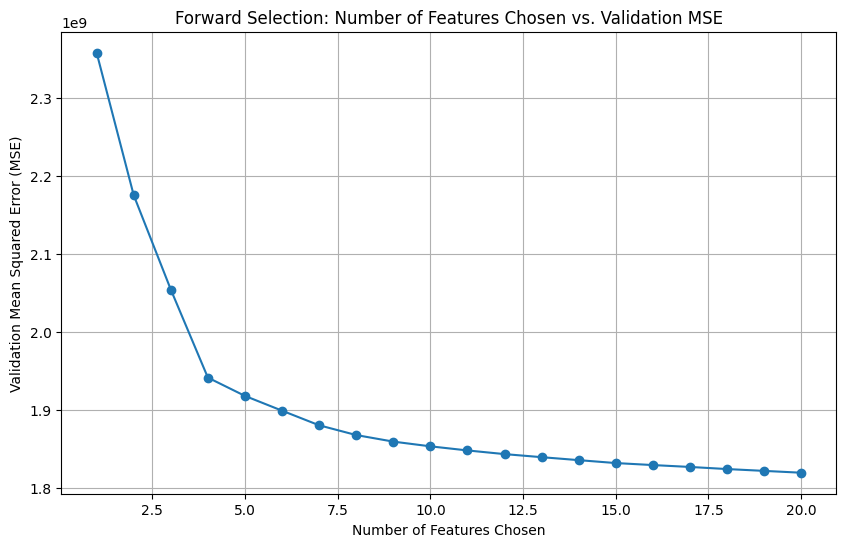

Forward Selection Model Performance on Validation Set:
Selected Features: [2, 49, 71, 58, 59, 67, 14, 50, 25, 37, 30, 44, 22, 23, 19, 35, 81, 0, 52, 69]
Mean Absolute Error (MAE): 21928.936058133437
Mean Squared Error (MSE): 1825418253.6656342
R-squared (R2): 0.5992595159124272


In [24]:
# Function to perform forward selection
def forward_selection(X_train, y_train, X_val, y_val, max_features=None):
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    best_score = float('inf')
    best_model = None
    scores = []

    while remaining_features and (max_features is None or len(selected_features) < max_features):
        feature_scores = []
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            model = LinearRegression()
            model.fit(X_train[:, features_to_try], y_train)
            y_val_pred = model.predict(X_val[:, features_to_try])
            score = mean_squared_error(y_val, y_val_pred)
            feature_scores.append((score, feature))

        feature_scores.sort()
        best_new_score, best_new_feature = feature_scores[0]

        if best_new_score < best_score:
            best_score = best_new_score
            selected_features.append(best_new_feature)
            remaining_features.remove(best_new_feature)
            best_model = model
            scores.append(best_new_score)
        else:
            break

    return best_model, selected_features, scores

# Perform forward selection
best_model, selected_features, scores = forward_selection(X_train_dense, y_train, X_val_dense, y_val, max_features=20)

# Plot the number of features chosen vs. validation MSE
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.xlabel('Number of Features Chosen')
plt.ylabel('Validation Mean Squared Error (MSE)')
plt.title('Forward Selection: Number of Features Chosen vs. Validation MSE')
plt.grid(True)
plt.show()

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_dense[:, selected_features])

# Evaluate the model performance
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Print the evaluation metrics
print(f"Forward Selection Model Performance on Validation Set:")
print(f"Selected Features: {selected_features}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Ridge Model after hyperparameter tuning

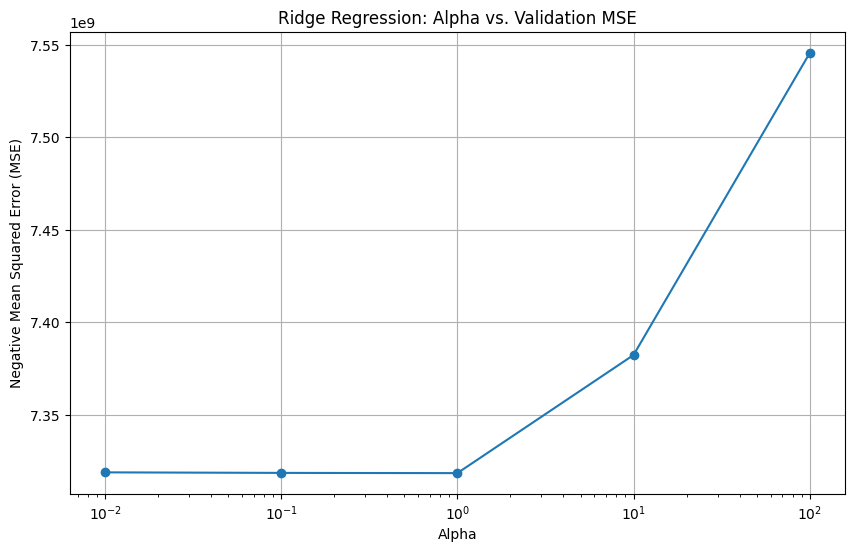

Ridge Regression Model Performance on Validation Set (after hyperparameter tuning):
Mean Absolute Error (MAE): 21703.450850926238
Mean Squared Error (MSE): 1822970253.3194544
R-squared (R2): 0.5997969340311542


In [27]:
# Define the parameter grid for Ridge regression
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize the Ridge regression model
ridge = Ridge()

# Perform Grid Search for Ridge regression
ridge_grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
ridge_grid_search.fit(X_train_dense[:, selected_features], y_train)
best_ridge = ridge_grid_search.best_estimator_

# Extract the results from the grid search
results = ridge_grid_search.cv_results_

# Plot the mean test scores for each alpha value
plt.figure(figsize=(10, 6))
plt.plot(param_grid['alpha'], -results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error (MSE)')
plt.title('Ridge Regression: Alpha vs. Validation MSE')
plt.grid(True)
plt.show()

# Make predictions on the validation set
y_val_pred_ridge = best_ridge.predict(X_val_dense[:, selected_features])

# Evaluate the Ridge regression model performance
mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the evaluation metrics for Ridge regression
print(f"Ridge Regression Model Performance on Validation Set (after hyperparameter tuning):")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R-squared (R2): {r2_ridge}")

LASSO Model after hyperparameter tuning

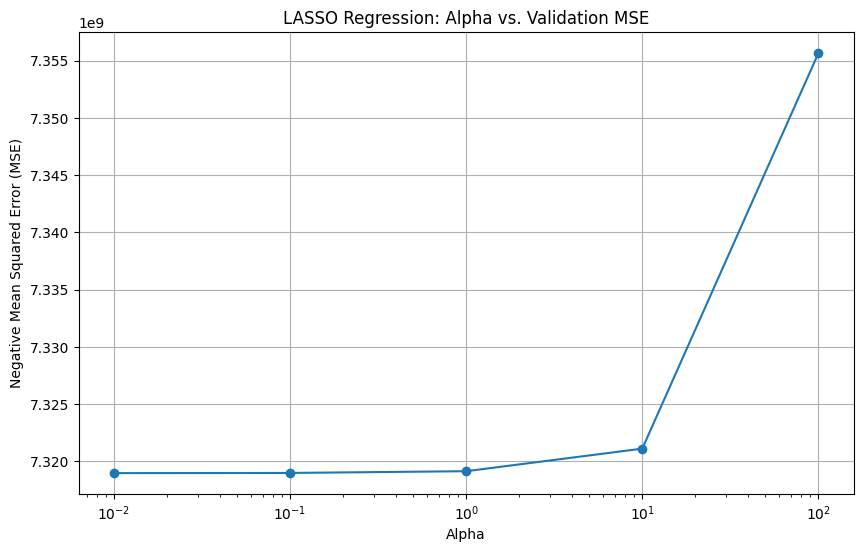

LASSO Regression Model Performance on Validation Set (after hyperparameter tuning):
Mean Absolute Error (MAE): 21729.357418165575
Mean Squared Error (MSE): 1819887610.7445183
R-squared (R2): 0.600473677388611


In [28]:
# Define the parameter grid for LASSO
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize the LASSO model
lasso = Lasso(max_iter=10000)

# Perform Grid Search for LASSO
lasso_grid_search = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
lasso_grid_search.fit(X_train_dense[:, selected_features], y_train)
best_lasso = lasso_grid_search.best_estimator_

# Extract the results from the grid search
results = lasso_grid_search.cv_results_

# Plot the mean test scores for each alpha value
plt.figure(figsize=(10, 6))
plt.plot(param_grid_lasso['alpha'], -results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error (MSE)')
plt.title('LASSO Regression: Alpha vs. Validation MSE')
plt.grid(True)
plt.show()

# Make predictions on the validation set
y_val_pred_lasso = best_lasso.predict(X_val_dense[:, selected_features])

# Evaluate the LASSO model performance
mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Print the evaluation metrics for LASSO
print(f"LASSO Regression Model Performance on Validation Set (after hyperparameter tuning):")
print(f"Mean Absolute Error (MAE): {mae_lasso}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"R-squared (R2): {r2_lasso}")

Polynomial Ridge Regression Model after hyperparameter tuning

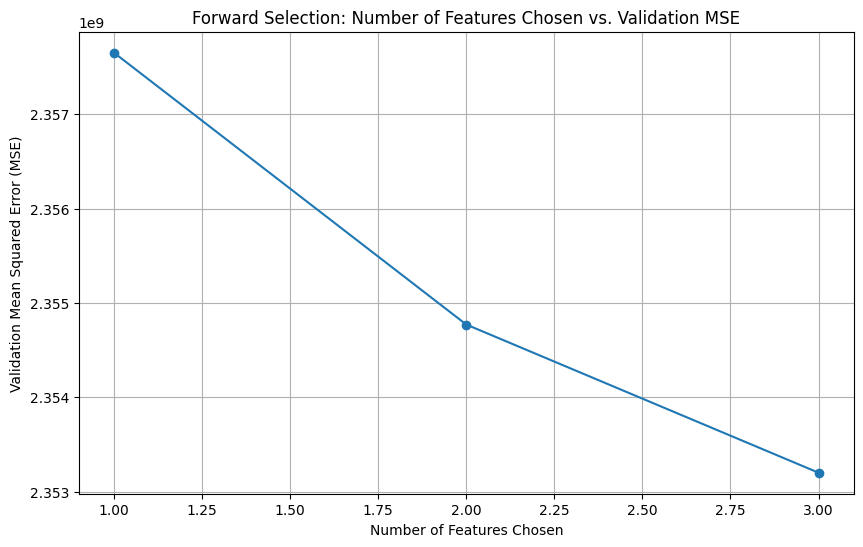

Selected Features: [2, 0, 4]


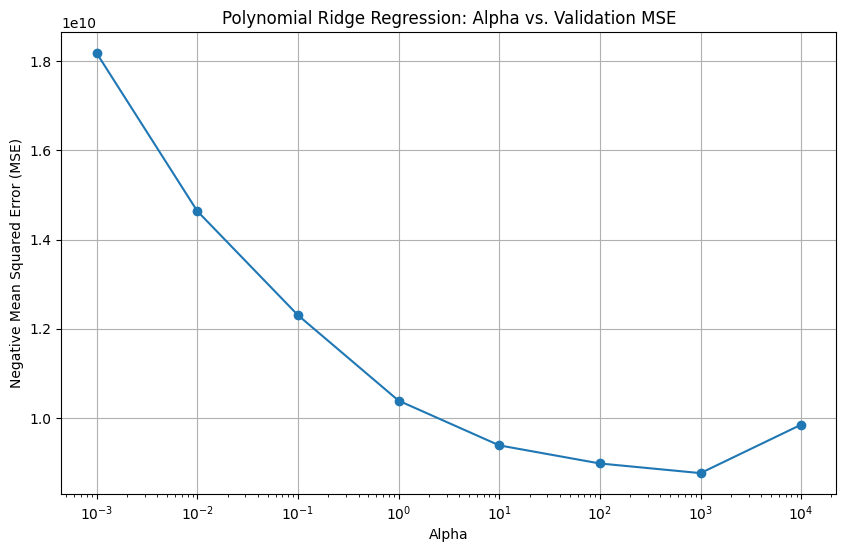

Polynomial Ridge Regression Model Performance on Validation Set (after hyperparameter tuning):
Mean Absolute Error (MAE): 25753.566594601096
Mean Squared Error (MSE): 2172751649.346257
R-squared (R2): 0.5230081949642973


In [54]:
# Function to perform forward selection
def forward_selection(X_train, y_train, X_val, y_val, max_features=None):
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    best_score = float('inf')
    best_model = None
    scores = []

    while remaining_features and (max_features is None or len(selected_features) < max_features):
        feature_scores = []
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            model = LinearRegression()
            model.fit(X_train[:, features_to_try], y_train)
            y_val_pred = model.predict(X_val[:, features_to_try])
            score = mean_squared_error(y_val, y_val_pred)
            feature_scores.append((score, feature))

        feature_scores.sort()
        best_new_score, best_new_feature = feature_scores[0]

        if best_new_score < best_score:
            best_score = best_new_score
            selected_features.append(best_new_feature)
            remaining_features.remove(best_new_feature)
            best_model = model
            scores.append(best_new_score)
        else:
            break

    return best_model, selected_features, scores

# Perform forward selection
best_model, selected_features_copy, scores = forward_selection(x_train_dense_copy, y_train_copy, x_val_dense_copy, y_val_copy, max_features=20)

# Plot the number of features chosen vs. validation MSE
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.xlabel('Number of Features Chosen')
plt.ylabel('Validation Mean Squared Error (MSE)')
plt.title('Forward Selection: Number of Features Chosen vs. Validation MSE')
plt.grid(True)
plt.show()

# Print the selected features
print(f"Selected Features: {selected_features_copy}")

# Define the parameter grid for Polynomial Ridge Regression
param_grid_poly_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

# Initialize the Polynomial Ridge Regression model
poly_ridge = make_pipeline(PolynomialFeatures(degree=4), Ridge())

# Perform Grid Search for Polynomial Ridge Regression
poly_ridge_grid_search = GridSearchCV(poly_ridge, param_grid_poly_ridge, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
poly_ridge_grid_search.fit(x_train_dense_copy[:, selected_features_copy], y_train_copy)
best_poly_ridge = poly_ridge_grid_search.best_estimator_

# Extract the results from the grid search
results = poly_ridge_grid_search.cv_results_

# Plot the mean test scores for each alpha value
plt.figure(figsize=(10, 6))
plt.plot(param_grid_poly_ridge['ridge__alpha'], -results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error (MSE)')
plt.title('Polynomial Ridge Regression: Alpha vs. Validation MSE')
plt.grid(True)
plt.show()

# Make predictions on the validation set
y_val_pred_poly_ridge = best_poly_ridge.predict(x_val_dense_copy[:, selected_features_copy])

# Evaluate the Polynomial Ridge Regression model performance
mae_poly_ridge = mean_absolute_error(y_val_copy, y_val_pred_poly_ridge)
mse_poly_ridge = mean_squared_error(y_val_copy, y_val_pred_poly_ridge)
r2_poly_ridge = r2_score(y_val_copy, y_val_pred_poly_ridge)

# Print the evaluation metrics for Polynomial Ridge Regression
print(f"Polynomial Ridge Regression Model Performance on Validation Set (after hyperparameter tuning):")
print(f"Mean Absolute Error (MAE): {mae_poly_ridge}")
print(f"Mean Squared Error (MSE): {mse_poly_ridge}")
print(f"R-squared (R2): {r2_poly_ridge}")

Testing the best model

Polynomial Ridge Regression (degree=7) Model Performance on Test Set:
Mean Absolute Error (MAE): 24744.176352233404
Mean Squared Error (MSE): 3503763522.566748
R-squared (R2): 0.7144920939506914


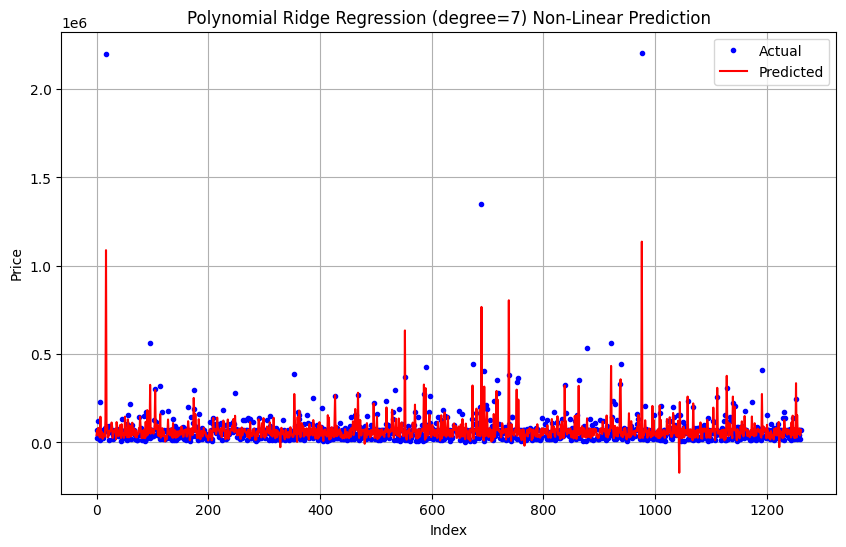

In [34]:
# Function to evaluate polynomial regression models with Ridge regularization and feature selection
def test_polynomial_ridge_regression(degree, k_best_features, alpha=20.0):
    model = make_pipeline(
        PolynomialFeatures(degree),
        SelectKBest(f_regression, k=k_best_features),
        Ridge(alpha=alpha)
    )
    model.fit(x_train_dense_copy, y_train_copy)
    y_test_pred = model.predict(x_test_dense_copy)
    mae = mean_absolute_error(y_test_copy, y_test_pred)
    mse = mean_squared_error(y_test_copy, y_test_pred)
    r2 = r2_score(y_test_copy, y_test_pred)
    print(f"Polynomial Ridge Regression (degree={degree}) Model Performance on Test Set:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2): {r2}")

    # Plot the non-linear prediction curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test_copy)), y_test_copy, 'b.', label='Actual')
    plt.plot(range(len(y_test_copy)), y_test_pred, 'r-', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title(f'Polynomial Ridge Regression (degree={degree}) Non-Linear Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

# Test polynomial ridge regression models with degrees from 7 and select top 85 features
test_polynomial_ridge_regression(7, k_best_features=85, alpha=20.0)